In [1]:


################################ GLOBAL VARIABLES ############################

########## DATA ##########
MODANET_ANNO = "modanet/annotations/modanet2018_instances_train.json"
MODANET_VAL =  "modanet/annotations/modanet2018_instances_val.json"
PAPERDOLL_META_DB = "data/paperdoll/chictopia.sqlite3"
PAPERDOLL_IMG_DB =  "data/paperdoll/photos.lmdb"



########## MODEL ##########
JOB_NAME = "MODANET"
MODEL_TYPE = 'resnet50'
NUM_CATS = 13
IMAGE_SIZE = 512 #INPUT IMAGE SIZE : IMAGE_SIZE * IMAGE_SIZE

GPU_NUM = 1 #1# 2# 4# #8
IMAGES_PER_GPU_PER_IT = 4 #4 

STEPS_PER_EPOCH_NUM = 500 #40000
VALIDATION_STEPS_NUM = 100

LR = 1e-4
#EPOCHS = [2, 4, 8, 16, 32, 64]
EPOCHS = [2, 4, 8, 9, 10, 11]

N_FOLDS = 5
SELECT_FOLD_IDX = 3

## pretrain data
FGVC6_WEIGHT_FIEL =  CURR_PATH + "/weight_files/mask_rcnn_FGVC6_0008.h5" 
LOG_DIR =  CURR_PATH + "/weight_files/logs"

###########################################################################
    


In [ ]:
import os
import io
import sys
import json
import random
import datetime
import cv2
import numpy as np
import pandas as pd
import skimage.draw
import skimage.io as imio
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold
import pylab
from PIL import Image
from IPython.display import display

import lmdb
import sqlite3

sys.path.append( "./mask_rcnn_lib")  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from tensorflow.contrib.tensorboard.plugins import projector

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# Train Model

In [ ]:

############################################################
#  Configurations
############################################################
#Photo data in LMDB

class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key) # binary image data
        if not data:
            return None
        
        with io.BytesIO(data) as f:
                image = Image.open(f)
                try:
                    image = image.convert("RGB")
                    image.load()
                except:
                    pass
                    
        return np.array(image)
    
        
    def __len__(self):
        return self.env.stat()['entries']


class ModaNetConfig(Config):
    def __init__(self, class_num=NUM_CATS, config_name=JOB_NAME):
        self.NUM_CLASSES = class_num + 1 # +1 for the background class
        self.NAME = config_name
        super().__init__()
      
    BACKBONE = MODEL_TYPE
    
    """     
    GPU_COUNT = GPU_NUM
    IMAGES_PER_GPU = IMAGES_PER_GPU_PER_IT 

    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = STEPS_PER_EPOCH_NUM

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    """    


############################################################
#  Dataset
############################################################

class ModaNetDataset(utils.Dataset):
    def __init__(self, photo_meta_db, coco, label_names, cat_ids):
        
        super().__init__(self)
        self.coco = coco
        self.label_names = label_names
        self.catIds = cat_ids
        self.photo_meta_db = photo_meta_db
        self.imgid2idx = {}
        self.count = 0
        
    def load_all_dataset(self):
        # Add classes
        for i, name in enumerate(self.label_names):
            self.add_class("fashion", i+1, name)
            
        # Add images and annotations
        for i, row in self.photo_meta_db.iterrows():
            
            annIds = self.coco.getAnnIds(imgIds=row['id'], catIds=self.catIds, iscrowd=None)
            anns = self.coco.loadAnns(annIds)
            catids, polygons = [], []
            for one in anns:
                catids.append(one['category_id'])
                polygons.extend(one['segmentation'])
                

            
            if len(polygons) == 0:
                continue
            
            fp = row['path'].split("?")[0]
            if False == fp.lower().endswith("jpg") and False == fp.lower().endswith("jpeg"):
                continue
                
            self.add_image("fashion", 
                           image_id = self.count,  #============> ID
                           path = CURR_PATH + "/data/paperdoll/images" + fp ,
                           labels = catids,
                           polygons = polygons,
                           height = row['height'], width=row['width'],
                           annotations = self.coco.loadAnns(self.coco.getAnnIds(
                            imgIds=row['id'], catIds=self.catIds, iscrowd=None)))

        
        print("load all data done, type :", self.class_info)
    
    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle
    
    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "fashion.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(ModaNetDataset, self).load_mask(image_id)

    def image_reference(self, image_id):
        return super(self.__class__, self).image_reference(image_id)


In [4]:

####### Photo Meta Data
access_str = "file:" + PAPERDOLL_META_DB + "?mode=ro"
meta_db = sqlite3.connect(access_str, uri=True)
photo_meta_db = pd.read_sql("""
            SELECT
                *
            FROM photos
            WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
        """, con=meta_db)

####### Image DataSet
photo_data_set = PhotoData(PAPERDOLL_IMG_DB)


####### Annotation Data
coco = COCO(MODANET_ANNO)


####### Model Config
config = ModaNetConfig()
config.display()

loading annotations into memory...
Done (t=4.96s)
creating index...
index created!


In [5]:
print(coco.getCatIds())
#id_set = coco.getImgIds(catIds=coco.getCatIds())
cats = coco.loadCats(coco.getCatIds())
print(cats)
label_names = [cat['name'] for cat in cats]
print(label_names)
cat_ids = coco.getCatIds(catNms = label_names)
print(cat_ids)

anno_img_id_set = []
for i in range(len(cat_ids)):
    anno_img_id_set.extend(coco.getImgIds(catIds=[i]))
print("total annotation number: ", len(anno_img_id_set))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
['bag', 'belt', 'boots', 'footwear', 'outer', 'dress', 'sunglasses', 'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf/tie']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
total annotation number:  211828


In [6]:
# drop  images meta entries that without annotation
anno_img_id_pd = pd.DataFrame({'id':anno_img_id_set})
anno_img_id_pd['id'] =anno_img_id_pd['id'].apply(int)
photo_meta_db = pd.merge(photo_meta_db, anno_img_id_pd, how='inner', on=['id'])
# drop duplicate
photo_meta_db = photo_meta_db.drop_duplicates()
print("photo_meta_db size: ", len(photo_meta_db))

photo_meta_db size:  52254


In [7]:
print(photo_meta_db.head())

     id  post_id                                               path  status  \
0     3       73  /photos/thefashbot/3613535083/3420751783/34207...       2   
4    13      142   /photos/thefashbot/2353856772/2353856772_400.jpg       2   
10  148       79     /photos/poppylee/3083327112/3083327112_400.jpg       2   
14  156      104     /photos/poppylee/8150270690/8150270690_400.jpg       2   
17  174      353     /photos/Carolina/7809452194/7809452194_400.jpg       2   

                    file_file_name  file_file_size file_content_type  \
0   open-uri20120907-29328-1uz77bi          115073        image/jpeg   
4     open-uri20120907-29328-s7gmu          106894        image/jpeg   
10  open-uri20120907-29328-1l7sf9u          124987        image/jpeg   
14   open-uri20120907-29328-v7lh6v          126139        image/jpeg   
17  open-uri20120907-29328-1x0oi3x          208504        image/jpeg   

               file_updated_at  width  height                  created_at  \
0   2012-09-07 

In [8]:
photo_meta_db = photo_meta_db.drop_duplicates()

In [10]:
dataset = ModaNetDataset(photo_meta_db, coco, label_names, cat_ids)
dataset.load_all_dataset()
dataset.prepare()

load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id': 11, 'name': 'skirt'}, {'source': 'fashion', 'id': 12, 'name': 'headwear'}, {'source': 'fashion', 'id': 13, 'name': 'scarf/tie'}]



(600, 400, 7) [6 7 5 8 4 4 5] 7 7 10
{'id': 0, 'source': 'fashion', 'path': '/root/workspace/product_image_segmentation/data/paperdoll/images/photos/toropiski/1905696948/9697010762/heather-gray-wool-dress-forest-green-leather-coat-black-tights_400.jpg', 'labels': [6, 7, 5, 8, 4, 4, 5], 'polygons': [[176, 140, 196, 144, 213, 148, 217, 147, 225, 159, 222, 171, 211, 192, 221, 199, 236, 194, 242, 191, 248, 215, 254, 238, 243, 246, 233, 246, 233, 277, 233, 291, 231, 312, 231, 331, 229, 347, 183, 344, 165, 344, 134, 342, 126, 342, 132, 316, 137, 257, 147, 233, 137, 237, 134, 224, 133, 209, 133, 197, 138, 184, 154, 175, 158, 190, 165, 197, 174, 187, 172, 176, 174, 168, 174, 158, 175, 147], [165, 104, 177, 104, 189, 103, 193, 103, 211, 102, 193, 106, 187, 113, 183, 115, 174, 109, 171, 115, 165, 110], [212, 126, 221, 128, 239, 143, 252, 151, 268, 159, 267, 165, 271, 178, 294, 255, 301, 299, 298, 307, 280, 313, 273, 314, 270, 318, 269, 392, 259, 395, 239, 390, 245, 370, 252, 262, 256, 240, 249,

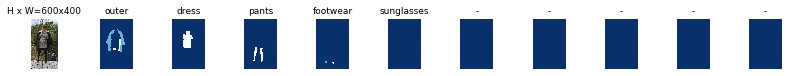


(600, 400, 5) [ 2  9 11  4  4] 5 5 5
{'id': 0, 'source': 'fashion', 'path': '/root/workspace/product_image_segmentation/data/paperdoll/images/photos/missmatchgirrrl/11253773498/carrot-orange-socks-heather-gray-sweater-black-forever-21-shoes-ivory-neck_400.jpg', 'labels': [2, 9, 11, 4, 4], 'polygons': [[171, 277, 186, 274, 204, 274, 211, 277, 230, 277, 244, 277, 249, 278, 251, 281, 233, 284, 208, 284, 196, 282, 182, 280], [177, 188, 163, 194, 158, 205, 153, 235, 146, 258, 139, 266, 135, 277, 126, 301, 120, 310, 134, 316, 140, 308, 158, 280, 165, 282, 172, 273, 189, 272, 217, 276, 242, 276, 250, 280, 256, 299, 256, 324, 262, 323, 273, 299, 285, 290, 298, 273, 331, 298, 340, 287, 316, 263, 290, 229, 266, 198, 256, 188, 247, 184, 228, 193, 228, 207, 224, 219, 223, 229, 220, 233, 222, 248, 215, 253, 207, 250, 206, 231, 205, 216, 199, 202, 199, 190, 194, 197], [169, 280, 153, 301, 137, 329, 136, 339, 119, 371, 116, 388, 99, 422, 110, 433, 111, 440, 120, 447, 137, 445, 139, 451, 151, 453, 16

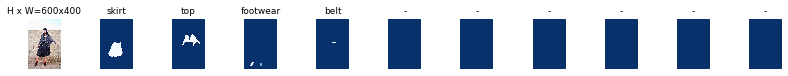


(600, 400, 5) [ 2 13  9  5 11] 5 5 7
{'id': 0, 'source': 'fashion', 'path': '/root/workspace/product_image_segmentation/data/paperdoll/images/photos/Losteardrop/6659329746/6659329746_400.jpg', 'labels': [2, 13, 9, 5, 11], 'polygons': [[235, 324, 228, 325, 225, 332, 206, 339, 191, 342, 181, 341, 174, 342, 160, 334, 152, 363, 177, 370, 194, 373, 209, 369, 191, 417, 174, 449, 174, 459, 183, 467, 193, 462, 205, 453, 229, 400, 236, 377, 237, 364, 245, 364, 239, 330, 236, 322], [189, 156, 182, 152, 169, 157, 167, 155, 159, 159, 170, 179, 164, 200, 163, 248, 167, 312, 171, 329, 214, 325, 199, 227, 187, 196, 181, 186, 189, 156], [167, 144, 153, 129, 147, 161, 133, 169, 158, 303, 156, 328, 173, 330, 167, 312, 162, 247, 165, 202, 171, 180, 159, 159, 167, 154, 167, 144], [196, 122, 179, 141, 168, 146, 169, 153, 185, 153, 190, 158, 182, 188, 187, 198, 199, 226, 214, 326, 235, 316, 220, 195, 214, 183, 216, 177, 211, 165, 200, 152, 198, 147, 198, 129, 197, 125], [116, 172, 103, 172, 91, 151, 73, 15

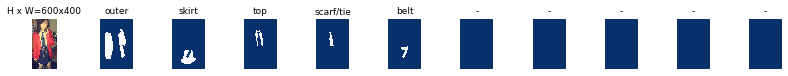

In [11]:
# CHECK THE DATABASE
for i in range(3):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)

    print(mask.shape, class_ids ,len(class_ids), len(dataset.image_info[image_id]['labels']),  len(dataset.image_info[image_id]['polygons']))
    print(dataset.image_info[image_id])
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=10)

In [12]:
print("category distribution: ")
total_num = 0
for i in cat_ids:
    print(i, len(coco.getImgIds(catIds=[i])))
    total_num += len(coco.getImgIds(catIds=[i]))
    
print(total_num)

category distribution: 
1 20570
2 14295
3 7084
4 39222
5 23691
6 14426
7 8792
8 23015
9 34681
10 7031
11 13575
12 5446
13 5020
216848


In [13]:
kf = KFold(n_splits=N_FOLDS, shuffle=True)
splits = kf.split(photo_meta_db) 

def get_fold(splits, train_df, idx):    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == idx:
            return train_df.iloc[train_index], train_df.iloc[valid_index]
        
train_df, valid_df = get_fold(splits, photo_meta_db, SELECT_FOLD_IDX)

print("train set size: " , len(train_df))
print("valid set size: " , len(valid_df))

train_dataset = ModaNetDataset(train_df, coco, label_names, cat_ids)
train_dataset.load_all_dataset()
train_dataset.prepare()


valid_dataset = ModaNetDataset(valid_df, coco, label_names, cat_ids)
valid_dataset.load_all_dataset()
valid_dataset.prepare()


train set size:  41803
valid set size:  10451
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id': 11, 'name': 'skirt'}, {'source': 'fashion', 'id': 12, 'name': 'headwear'}, {'source': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'i

In [17]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOG_DIR)   
model_path =\
    "/root/workspace/product_image_segmentation/weight_files/logs/modanet20190718T1840/mask_rcnn_modanet_0007.h5"
model.load_weights(model_path, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])


Re-starting from epoch 7


In [14]:

def get_fold(splits, train_df, idx):    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == idx:
            return train_df.iloc[train_index], train_df.iloc[valid_index]
        

def split_dateset(photo_meta_db, N_FOLDS, coco, label_names, cat_ids):
    selected = random.randint(0,10000)%N_FOLDS

    kf = KFold(n_splits=N_FOLDS, shuffle=True)
    splits = kf.split(photo_meta_db) 
 
    train_set, valid_set = get_fold(splits, photo_meta_db, selected)


    train_dataset = ModaNetDataset(train_set, coco, label_names, cat_ids)
    train_dataset.load_all_dataset()
    train_dataset.prepare()
    print("train set size: " , len(train_set), type(train_dataset))

    valid_dataset = ModaNetDataset(valid_set, coco, label_names, cat_ids)
    valid_dataset.load_all_dataset()
    valid_dataset.prepare()
    print("valid set size: " , len(valid_set), type(valid_dataset))
    
    return train_dataset, valid_dataset



In [ ]:
epo = 0
LRs = [20, 15, 5, 10, 3, 5, 0.7, 0.3, 13, 0.7, 11, 17, 0.7, 0.3,20, 15, 5, 10]
while epo < len(LRs):
    train_set, valid_set = split_dateset(photo_meta_db, N_FOLDS, coco, label_names, cat_ids)

    model.train(train_set, valid_set,
            learning_rate = LR * LRs[epo],
            epochs = epo + 8,
            layers = 'all',
            augmentation=None)
    print("One epoch done, NO.: {}  LR: {}".format(epo+8, LRs[epo]))
    epo = epo + 1
    

load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id': 11, 'name': 'skirt'}, {'source': 'fashion', 'id': 12, 'name': 'headwear'}, {'source': 'fashion', 'id': 13, 'name': 'scarf/tie'}]
train set size:  41804 <class '__main__.ModaNetDataset'>
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'f

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 8/8
1000/1000 [==============================] - 2769s 3s/step - loss: 1.1903 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.3448 - mrcnn_class_loss: 0.3202 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2879 - val_loss: 1.4447 - val_rpn_class_loss: 0.0217 - val_rpn_bbox_loss: 0.5336 - val_mrcnn_class_loss: 0.3251 - val_mrcnn_bbox_loss: 0.2755 - val_mrcnn_mask_loss: 0.2887
One epoch done, NO.: 8  LR: 20
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id': 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 9/9
1000/1000 [==============================] - 2796s 3s/step - loss: 1.0879 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2782 - mrcnn_class_loss: 0.3193 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2703 - val_loss: 1.7671 - val_rpn_class_loss: 0.0307 - val_rpn_bbox_loss: 0.6272 - val_mrcnn_class_loss: 0.5185 - val_mrcnn_bbox_loss: 0.2914 - val_mrcnn_mask_loss: 0.2993
One epoch done, NO.: 9  LR: 15
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id': 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 10/10
1000/1000 [==============================] - 2779s 3s/step - loss: 1.1644 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.3632 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.2559 - val_loss: 1.4295 - val_rpn_class_loss: 0.0288 - val_rpn_bbox_loss: 0.4207 - val_mrcnn_class_loss: 0.4405 - val_mrcnn_bbox_loss: 0.2521 - val_mrcnn_mask_loss: 0.2874
One epoch done, NO.: 10  LR: 5
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id'

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 11/11
1000/1000 [==============================] - 2860s 3s/step - loss: 1.0703 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2938 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.1955 - mrcnn_mask_loss: 0.2536 - val_loss: 1.5468 - val_rpn_class_loss: 0.0448 - val_rpn_bbox_loss: 0.5982 - val_mrcnn_class_loss: 0.3814 - val_mrcnn_bbox_loss: 0.2345 - val_mrcnn_mask_loss: 0.2878
One epoch done, NO.: 11  LR: 10
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 12/12
1000/1000 [==============================] - 2851s 3s/step - loss: 1.1509 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.3507 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.2630 - val_loss: 1.2130 - val_rpn_class_loss: 0.0135 - val_rpn_bbox_loss: 0.2877 - val_mrcnn_class_loss: 0.4208 - val_mrcnn_bbox_loss: 0.2118 - val_mrcnn_mask_loss: 0.2792
One epoch done, NO.: 12  LR: 3
load all data done, type : [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'fashion', 'id': 1, 'name': 'bag'}, {'source': 'fashion', 'id': 2, 'name': 'belt'}, {'source': 'fashion', 'id': 3, 'name': 'boots'}, {'source': 'fashion', 'id': 4, 'name': 'footwear'}, {'source': 'fashion', 'id': 5, 'name': 'outer'}, {'source': 'fashion', 'id': 6, 'name': 'dress'}, {'source': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'source': 'fashion', 'id': 8, 'name': 'pants'}, {'source': 'fashion', 'id': 9, 'name': 'top'}, {'source': 'fashion', 'id': 10, 'name': 'shorts'}, {'source': 'fashion', 'id'

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 13/13
 310/1000 [========>.....................] - ETA: 33:36 - loss: 1.0741 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2528 - mrcnn_class_loss: 0.3381 - mrcnn_bbox_loss: 0.1970 - mrcnn_mask_loss: 0.2694